<a href="https://colab.research.google.com/github/Staneering/Covid19-Vaccination-Forecasting/blob/main/VaccinationRateforKenya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'latest-covid-19-dataset-worldwide:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1852043%2F3023973%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240502%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240502T125445Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D557f7a235941f94e7cd7aebb367f208c8a109d9acbb10ed771828d70448de27899da426c01da580342adcc32d01f90f379be95aa33b2f6fab41acb1ab0f7a255e81b47da9336a46bdacfb3d9fe1fa3bca49a1fb3d3b2328c09e5365a41080080b7d20b7592e2177e1d0b7320af99501c044ebc93a900a62372743497e112555ed667f42d423277e39182e6f3c2e40ce065425d1663b59044fef63a0f1cfe12263d0ff2c1c7fb8ba5d808e678b922d9488fa11c3e3d1e027145c8aac6cfcbd3f0537002f1cca6112b284adcd922e7a02c4963048962a172ddda3a1ead7430d7d740f649dfe38bfdbaf9cfb2ab89f35869fdcb9a1ae0391d943af23883ca2179b8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 8526536 bytes downloaded
Downloaded and uncompressed: latest-covid-19-dataset-worldwide
Data source import complete.


In [ ]:
import numpy as np  # Lineal algebra
import pandas as pd # Data wrangling
from statsmodels.tsa.arima.model import ARIMA #ARIMA model (arima_model is deprecated, use this one instead!)
from statsmodels.tsa.stattools import adfuller #Dickey-Fuller test for stationarity

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
df = pd.read_csv('../input/latest-covid-19-dataset-worldwide/owid-covid-data (2).csv')

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df = df[df['iso_code']=='KEN']
df = df.set_index('date')
hospitalized = df[['new_vaccinations_smoothed']]
hospitalized = hospitalized.resample('W-MON').mean()

<Axes: xlabel='date'>

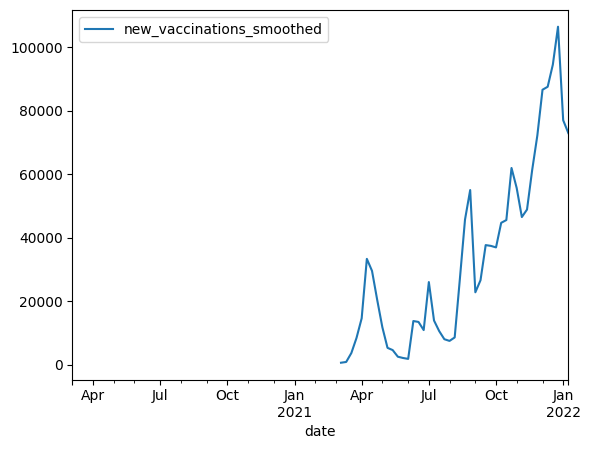

In [ ]:
hospitalized.plot()

In [ ]:
hospitalized = hospitalized.dropna()

<Axes: xlabel='date'>

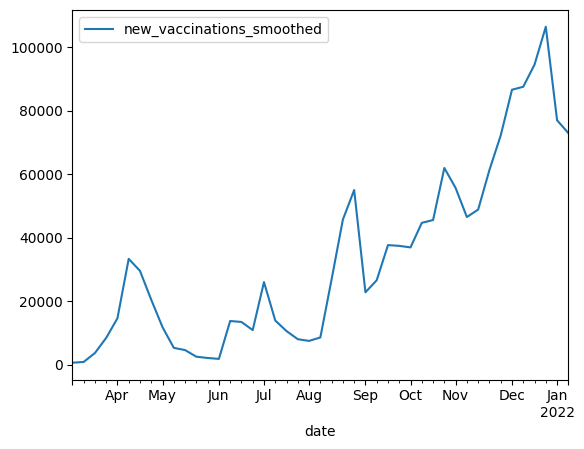

In [ ]:
hospitalized.plot()

<Axes: xlabel='date'>

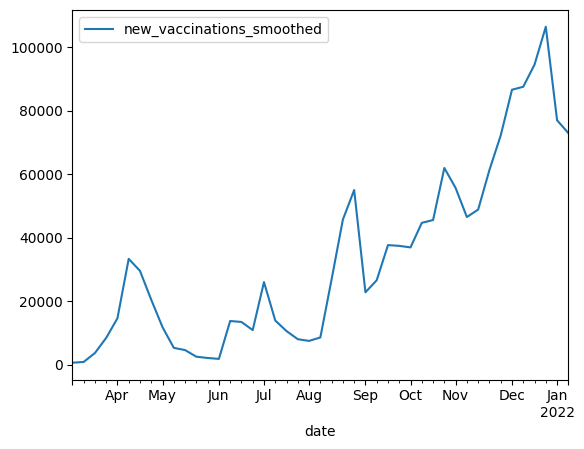

In [ ]:
#hospitalized = np.log(hospitalized) # Apply a log transformation to reduce heterocedasticity
hospitalized.plot()

In [ ]:
result = adfuller(hospitalized)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.119054
p-value: 0.707414


In [ ]:
diffhosp = hospitalized.diff().dropna() # Save the first difference
result = adfuller(diffhosp)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.162295
p-value: 0.000010


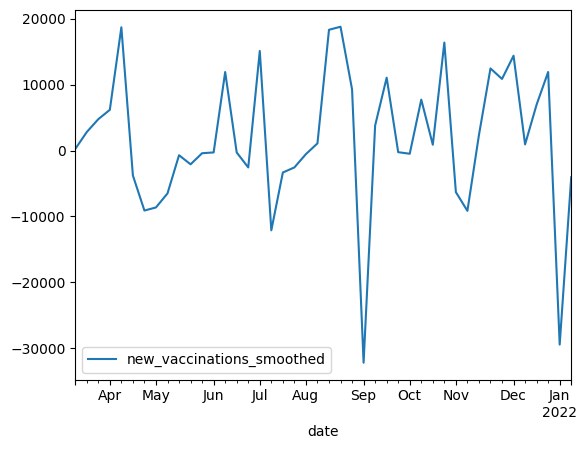

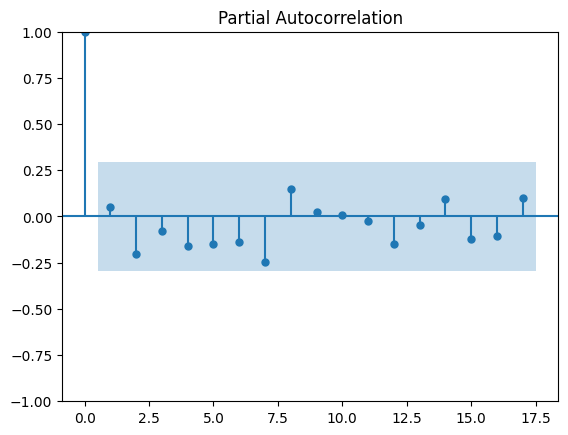

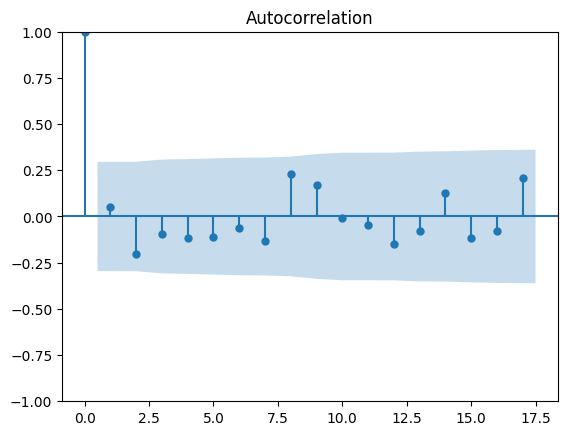

In [ ]:
diffhosp.plot()
pacf =  plot_pacf(diffhosp)
acf =  plot_acf(diffhosp)

In [ ]:
model = ARIMA(hospitalized,order= (2,1,2)).fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     new_vaccinations_smoothed   No. Observations:                   45
Model:                        ARIMA(2, 1, 2)   Log Likelihood                -469.999
Date:                       Thu, 02 May 2024   AIC                            949.998
Time:                               22:33:24   BIC                            958.919
Sample:                           03-08-2021   HQIC                           953.307
                                - 01-10-2022                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3882      1.160      0.335      0.738      -1.885       2.661
ar.L2         -0.0110      0.823     -0.013      0.989      -1.624       1.602
ma.L1         -0.3216      1.162     -0.277      0.782      -2.599       1.956
ma.L2         -0.2289      0.877     -0.261      0.794      -1.948       1.491
sigma2      1.189e+08   1.29e-08   9.23e+15      0.000    1.19e+08    1.19e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 6.97
Prob(Q):                              0.69   Prob(JB):                         0.03
Heteroskedasticity (H):               2.81   Skew:                            -0.74
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.36e+32. Standard errors may be unstable.
"""

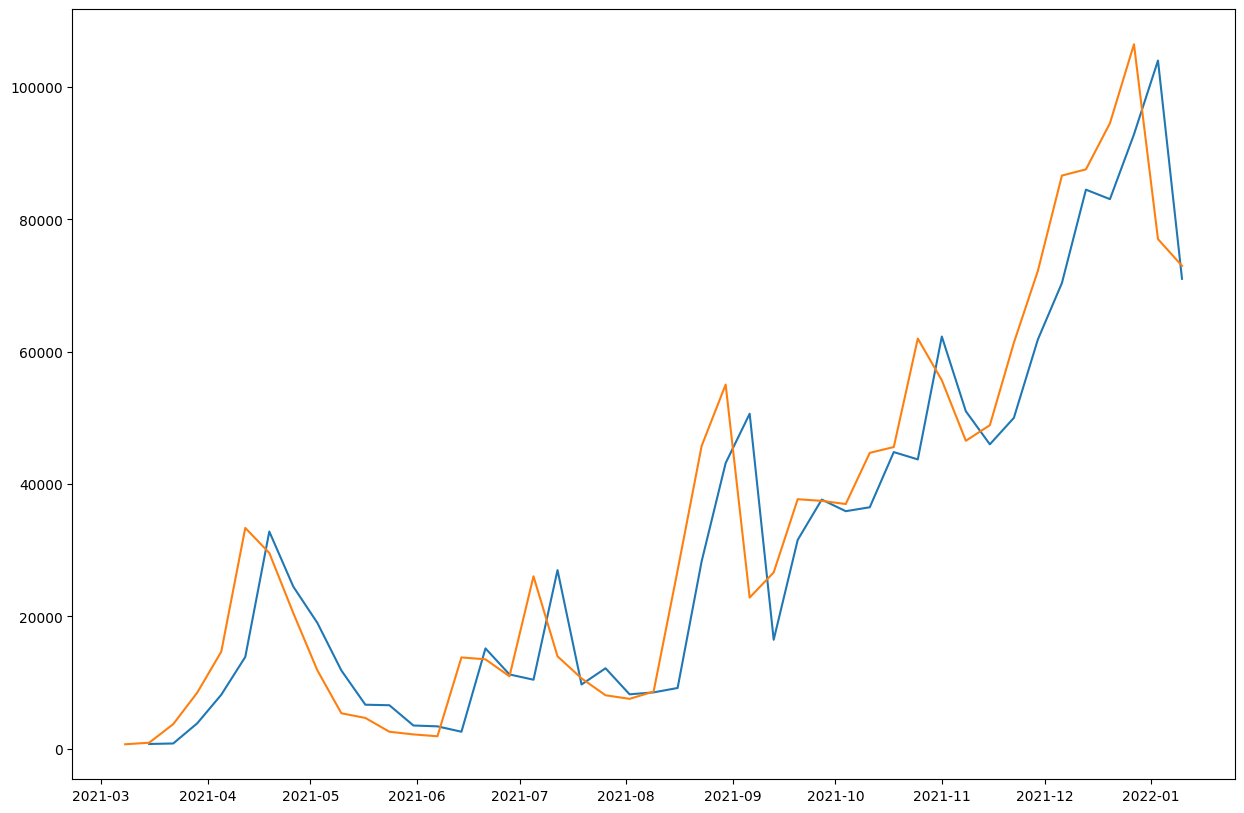

In [ ]:
predictions = model.predict()
plt.figure(figsize=(15,10))
plt.plot(predictions[1:])
plt.plot(hospitalized)

In [ ]:
train = hospitalized[:-5]
test = hospitalized[-5:]
model = ARIMA(train,order= (2,1,2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     new_vaccinations_smoothed   No. Observations:                   40
Model:                        ARIMA(2, 1, 2)   Log Likelihood                -413.950
Date:                       Thu, 02 May 2024   AIC                            837.900
Time:                               22:33:26   BIC                            846.218
Sample:                           03-08-2021   HQIC                           840.884
                                - 12-06-2021                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8716      0.727      1.199      0.230      -0.553       2.296
ar.L2         -0.4358      0.813     -0.536      0.592      -2.030       1.159
ma.L1         -0.7805      0.798     -0.979      0.328      -2.344       0.783
ma.L2          0.1769      0.927      0.191      0.849      -1.639       1.993
sigma2      1.044e+08   1.86e-08   5.61e+15      0.000    1.04e+08    1.04e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.68   Prob(JB):                         0.48
Heteroskedasticity (H):               2.08   Skew:                            -0.32
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.81e+32. Standard errors may be unstable.
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


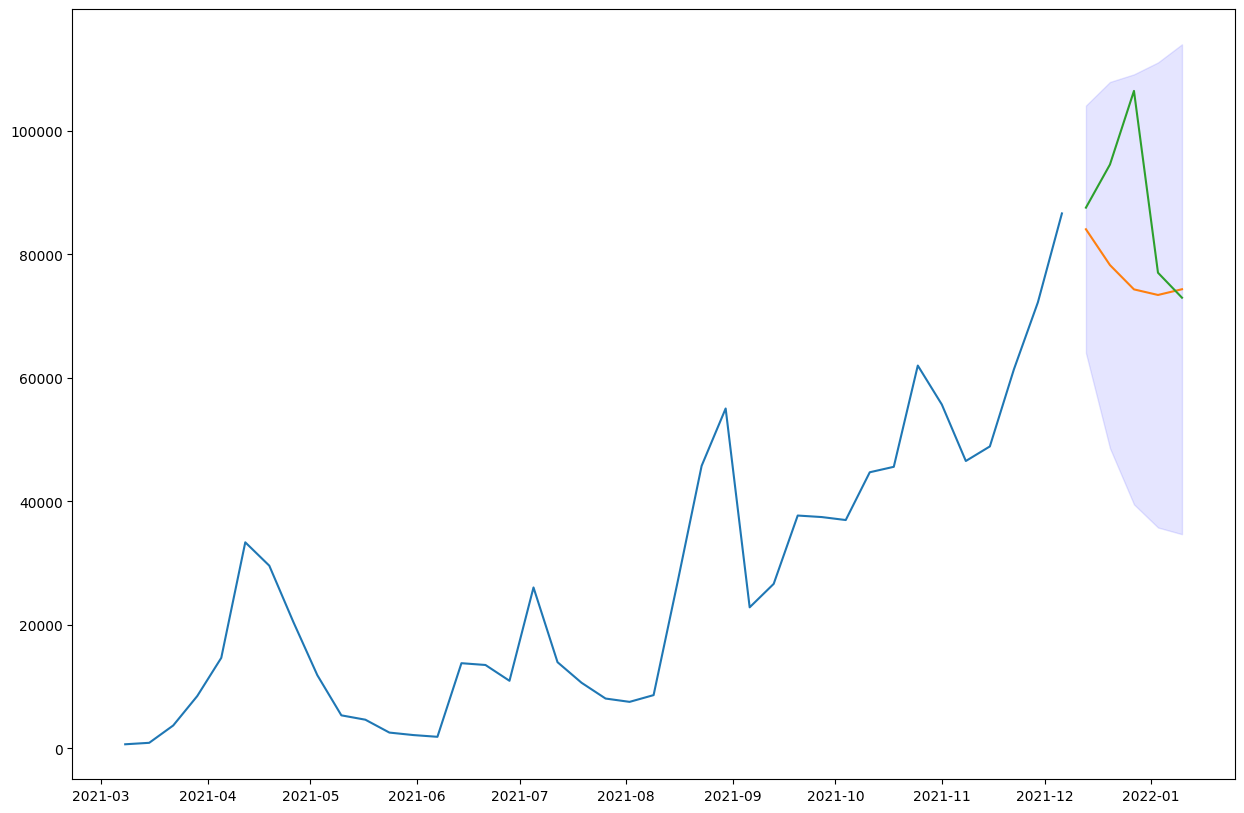

In [ ]:
predictions = model.get_forecast(5,alpha = 0.95)
plt.figure(figsize=(15,10))
plt.plot((train))
plt.plot((predictions.predicted_mean))
plt.plot((test))
conf= predictions.conf_int(alpha=0.05)
upper = (conf['lower new_vaccinations_smoothed'])
lower = (conf['upper new_vaccinations_smoothed'])
plt.fill_between(upper.index, upper,lower, color='b', alpha=.1)

In [ ]:
size = int(len(hospitalized) * 0.66)
train, test = hospitalized[0:size], hospitalized[size:len(hospitalized)]
prediction = []
data = train.values
for t in test.values:
    model = model = ARIMA(data,order= (2,1,2)).fit()
    y = model.forecast()
    prediction.append(y[0])
    data = np.append(data, t)
test_res = pd.DataFrame(test)
test_res['preds'] = prediction

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


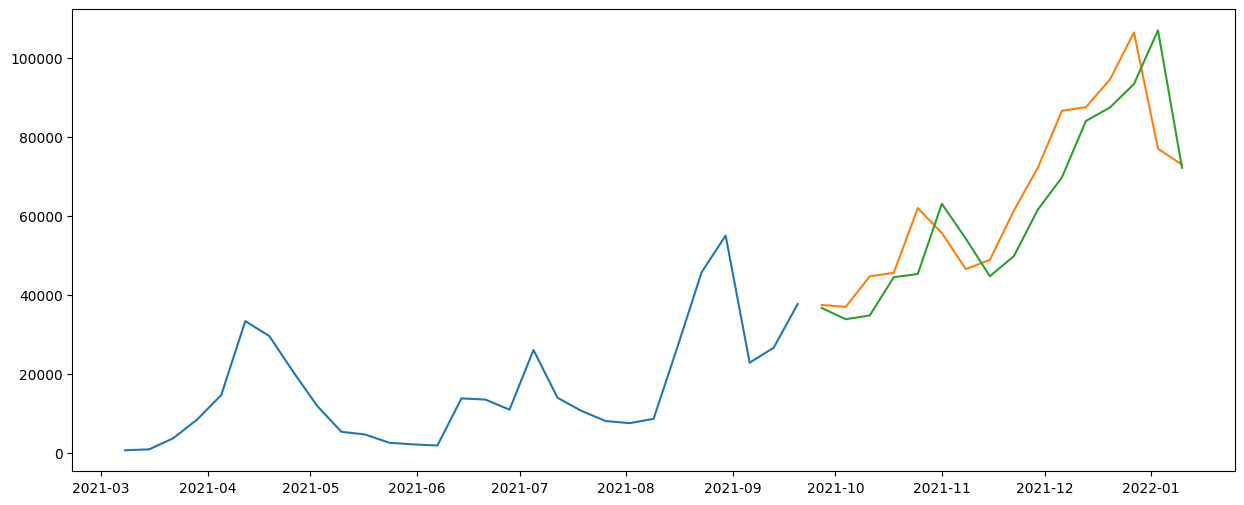

In [ ]:
plt.figure(figsize=(15,6))
plt.plot((train))
plt.plot((test_res))

In [ ]:
for column_name in df.columns:
  df[column_name] = pd.to_numeric(df[column_name], errors='coerce')

corr = df.corr()
hospcorr = corr['new_vaccinations_smoothed']
hospcorr = hospcorr[np.abs(hospcorr)>0.4]
hospcorr.sort_values()

tests_per_case                               -0.849272
stringency_index                             -0.786306
total_boosters_per_hundred                   -0.689940
total_boosters                               -0.667609
new_deaths_smoothed                          -0.486169
new_deaths_smoothed_per_million              -0.486035
new_deaths                                   -0.438265
new_deaths_per_million                       -0.438113
new_tests_smoothed_per_thousand               0.724000
new_tests_smoothed                            0.724472
new_vaccinations                              0.750866
total_deaths                                  0.767129
total_deaths_per_million                      0.767130
total_cases                                   0.792181
total_cases_per_million                       0.792181
total_tests                                   0.850015
total_tests_per_thousand                      0.850019
positive_rate                                 0.859243
people_ful

In [ ]:
exogfeats = df[['stringency_index','total_deaths_per_million','total_cases_per_million']]


In [ ]:
for column in exogfeats.columns:
  exogfeats[column]= exogfeats[column].fillna(exogfeats[column].mean())

<ipython-input-20-0de7495149cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exogfeats[column]= exogfeats[column].fillna(exogfeats[column].mean())


In [ ]:
exogfeats = exogfeats.resample('W-MON').mean()
exogfeats = exogfeats.iloc[(exogfeats.index >= hospitalized.first_valid_index()) & (exogfeats.index<= hospitalized.last_valid_index())]

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

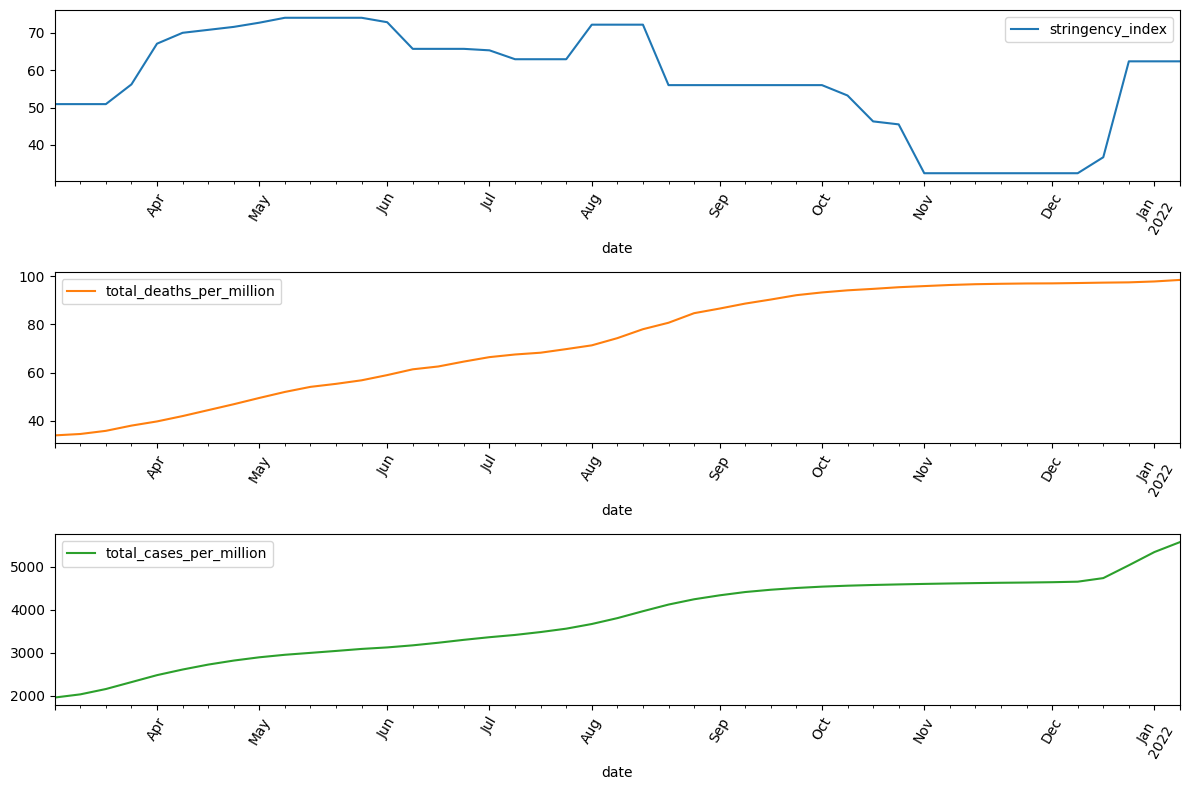

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8), tight_layout=True)
exogfeats.plot(ax=ax, subplots=True, rot=60)

In [ ]:
model = ARIMA(hospitalized,order= (2,1,2),exog=exogfeats).fit()
predictions = model.predict()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     new_vaccinations_smoothed   No. Observations:                   45
Model:                        ARIMA(2, 1, 2)   Log Likelihood                -468.099
Date:                       Thu, 02 May 2024   AIC                            952.199
Time:                               22:33:41   BIC                            966.472
Sample:                           03-08-2021   HQIC                           957.492
                                - 01-10-2022                                         
Covariance Type:                         opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
stringency_index           459.1090    267.582      1.716      0.086     -65.342     983.560
total_deaths_per_million  2218.3220   1622.995      1.367      0.172    -962.689    5399.333
total_cases_per_million    -33.3148     27.262     -1.222      0.222     -86.747      20.118
ar.L1                        0.2645      0.912      0.290      0.772      -1.524       2.053
ar.L2                       -0.0020      0.778     -0.003      0.998      -1.528       1.524
ma.L1                       -0.1198      0.960     -0.125      0.901      -2.002       1.762
ma.L2                       -0.2745      0.835     -0.329      0.742      -1.912       1.363
sigma2                    1.072e+08      0.001   1.74e+11      0.000    1.07e+08    1.07e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.92   Prob(JB):                         0.70
Heteroskedasticity (H):               1.58   Skew:                            -0.27
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.03e+29. Standard errors may be unstable.
"""

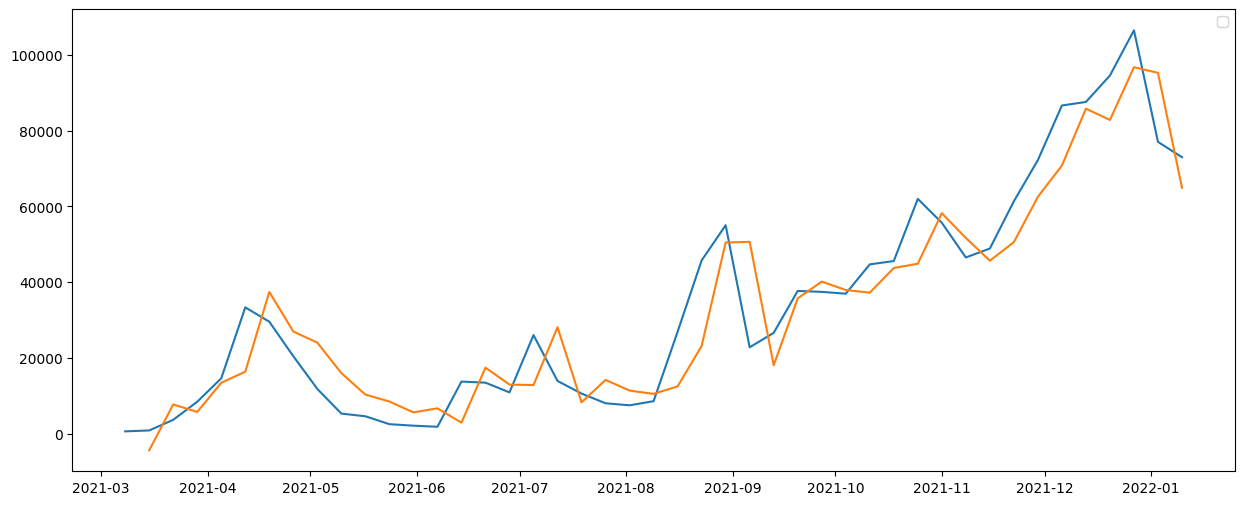

In [ ]:
plt.figure(figsize=(15,6))
plt.legend(["a","b"])
plt.plot(hospitalized)
plt.plot(predictions[1:])
plt.show()

In [ ]:
test_length = 5
train = hospitalized[:-test_length]
test = hospitalized[-test_length:]
train_exog = exogfeats[:-test_length]
test_exog = exogfeats[-test_length:]
model = ARIMA(train,order= (2,1,2),exog=train_exog).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


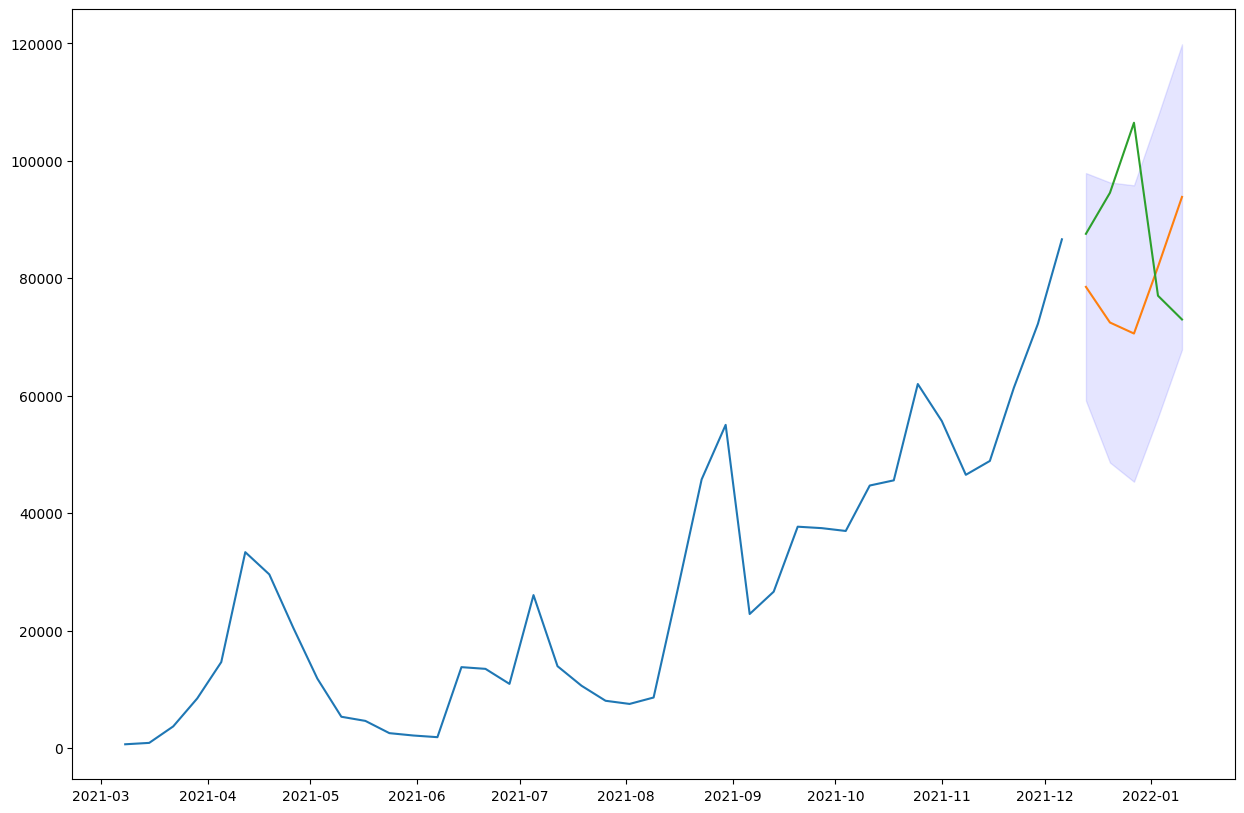

In [ ]:
predictions = model.get_forecast(5,exog = test_exog,alpha = 0.95)
plt.figure(figsize=(15,10))
plt.plot((train))
plt.plot((predictions.predicted_mean))
plt.plot((test))
conf= predictions.conf_int(alpha=0.05)
upper = (conf['lower new_vaccinations_smoothed'])
lower = (conf['upper new_vaccinations_smoothed'])
plt.fill_between(upper.index, upper,lower, color='b', alpha=.1)